# Introduction

The goal of this project is to develop a robust machine learning classifier capable of identifying accents in voice data based on extracted audio features. By leveraging a combination of fundamental voice attributes—such as MFCC (Mel-frequency cepstral coefficients), F0 statistics (pitch-related features), and ZCR (zero-crossing rate)—we aim to distinguish between accents from various regions. These features provide a rich representation of the acoustic properties of speech, enabling effective classification.

To achieve this, we utilize multiple machine learning algorithms:
1. **Decision Tree**: A simple yet interpretable classifier that recursively splits the data based on feature values.
2. **Random Forest**: An ensemble method that combines multiple decision trees for improved accuracy and robustness.
3. **Support Vector Machine (SVM)**: A powerful algorithm that identifies the optimal hyperplane for separating classes in a high-dimensional space.

Each algorithm is trained and evaluated using performance metrics such as accuracy, ROC AUC, and confusion matrices. Principal Component Analysis (PCA) and Sparse PCA are also applied to reduce dimensionality and visualize feature distributions, offering deeper insights into the structure of the data. Through these methods, we aim to compare the classifiers' effectiveness and identify the best approach for accent classification.

For refrence, in the models below,
* 0.0	United States English
* 1.0	England English
* 2.0	Canadian English
* 3.0	Australian English
* 4.0	India and South Asia (India, Pakistan, Sri Lanka)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.decomposition import PCA, SparsePCA
import matplotlib.pyplot as plt

data_dir = 'C:/Users/lukeh/OneDrive/Documents/College/Topics in Data Science/Unit 2/voice_clip_selected/'
voice_feature = pd.read_csv(data_dir + "voice_feature_20241022.csv")

accents_name = [
    "United States English",
    "England English",
    "Canadian English",
    "Australian English",
    "India and South Asia (India, Pakistan, Sri Lanka)",
]
accents_value = [0, 1, 2, 3, 4]
accents_dict = dict(zip(accents_name, accents_value))
voice_feature['accents'] = voice_feature['accents'].map(accents_dict)
voice_feature.dropna(inplace=True)

col_list_mfcc = [f'mfcc_{i:02}' for i in range(25)]
col_list_f0 = ['f0_mean', 'f0_std', 'f0_var', 'f0_min', 'f0_max', 'f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean', 'zcr_std', 'zcr_var', 'zcr_min', 'zcr_max', 'zcr_skew', 'zcr_kurtosis']

# Feature set and labels
X = voice_feature[col_list_f0 + col_list_mfcc + col_list_zcr]
y = voice_feature['accents']

scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=7)


### Decision Tree 

Decision Tree Metrics:
Accuracy: 0.6676
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      2289
         1.0       0.51      0.53      0.52       680
         2.0       0.43      0.44      0.43       239
         3.0       0.41      0.42      0.42       183
         4.0       0.26      0.24      0.25       138

    accuracy                           0.67      3529
   macro avg       0.48      0.48      0.48      3529
weighted avg       0.67      0.67      0.67      3529



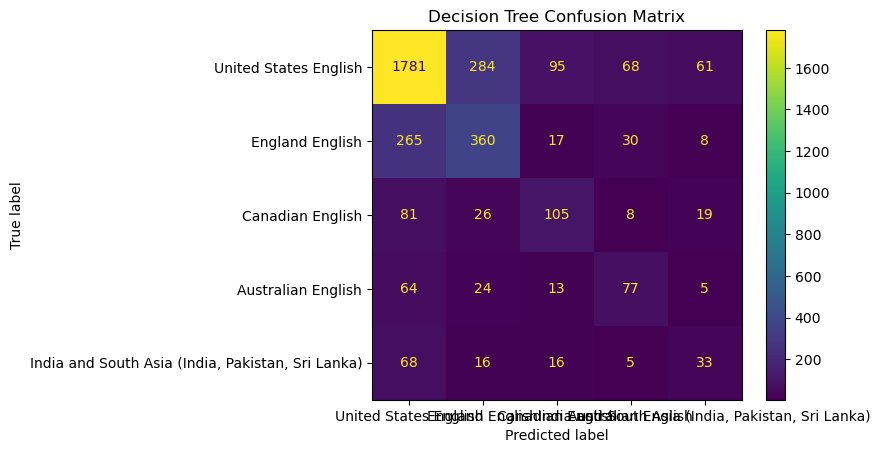

Decision Tree Rules:
|--- zcr_skew <= 0.32
|   |--- mfcc_10 <= 0.46
|   |   |--- mfcc_08 <= 0.43
|   |   |   |--- f0_var <= 0.00
|   |   |   |   |--- mfcc_03 <= 0.39
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- mfcc_03 >  0.39
|   |   |   |   |   |--- mfcc_08 <= 0.43
|   |   |   |   |   |   |--- class: 3.0
|   |   |   |   |   |--- mfcc_08 >  0.43
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- f0_var >  0.00
|   |   |   |   |--- mfcc_15 <= 0.16
|   |   |   |   |   |--- mfcc_04 <= 0.41
|   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |--- mfcc_04 >  0.41
|   |   |   |   |   |   |--- mfcc_11 <= 0.72
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- mfcc_11 >  0.72
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- mfcc_15 >  0.16
|   |   |   |   |   |--- mfcc_07 <= 0.29
|   |   |   |   |   |   |--- mfcc_06 <= 0.70
|   |   |   |   |   |   |   |--- mfcc_12 <= 0.56
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   | 

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_text

clf_tree = DecisionTreeClassifier(random_state=7)
clf_tree.fit(X_train, y_train)

y_pred_tree = clf_tree.predict(X_test)

print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_tree)}")
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(conf_matrix_tree, display_labels=accents_name).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

print("Decision Tree Rules:")
print(export_text(clf_tree, feature_names=col_list_f0 + col_list_mfcc + col_list_zcr))


### Discussion 

The Decision Tree classifier achieved an overall accuracy of **66.76%** in predicting accents from voice data. The model performed best in identifying **United States English (Class 0)**, with a precision of **0.79**, a recall of **0.78**, and an F1-score of **0.78**, likely due to a larger sample size providing more robust splits. However, performance declined for other accents:

- **England English (Class 1)**: Precision and recall were moderate (**0.51** and **0.53**, respectively), indicating room for improvement in distinguishing this accent.
- **Canadian English (Class 2)**: The model struggled with both precision and recall (**0.43** each), reflecting limited differentiation for this accent.
- **Australian English (Class 3)**: Similar to Canadian English, results were modest, with a precision of **0.41** and recall of **0.42**.
- **Indian and South Asian English (Class 4)**: The lowest performance was observed here, with a precision of **0.26** and recall of **0.24**, likely due to the small sample size and higher complexity in distinguishing these features.

The **macro average** F1-score of **0.48** reflects the imbalance in performance across classes, while the **weighted average** F1-score of **0.67** aligns with the dominance of the majority class (**United States English**). 

### Random Forest

Random Forest Metrics:
Accuracy: 0.7591
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84      2289
         1.0       0.96      0.41      0.58       680
         2.0       1.00      0.25      0.40       239
         3.0       1.00      0.22      0.36       183
         4.0       1.00      0.12      0.22       138

    accuracy                           0.76      3529
   macro avg       0.94      0.40      0.48      3529
weighted avg       0.82      0.76      0.71      3529



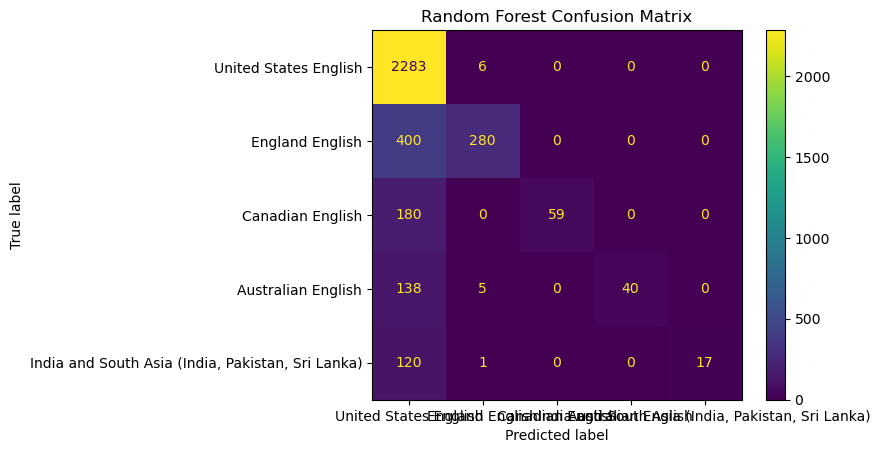

NameError: name 'label_binarize' is not defined

In [3]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=7)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
y_pred_prob_rf = clf_rf.predict_proba(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=accents_name).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### Discussion

The Random Forest classifier achieved an overall accuracy of **75.91%**, representing an improvement over the Decision Tree model. The classifier performed exceptionally well in identifying **United States English (Class 0)**, with a precision of **0.73**, a recall of **1.00**, and an F1-score of **0.84**. However, while the model showed high precision for other accents, recall scores varied significantly, particularly for underrepresented classes:

- **England English (Class 1)**: Precision was very high (**0.96**), but recall dropped to **0.41**, indicating that many instances of this accent were misclassified.
- **Canadian English (Class 2)**: Precision reached **1.00**, but recall was only **0.25**, suggesting overfitting to certain patterns at the expense of generalization.
- **Australian English (Class 3)**: Similar to Canadian English, precision was **1.00**, but recall was limited to **0.22**.
- **Indian and South Asian English (Class 4)**: Precision was again **1.00**, but recall was only **0.12**, reflecting significant challenges in identifying this accent.

The **macro average** F1-score of **0.48** highlights the imbalance in recall and F1-scores across classes, while the **weighted average** F1-score of **0.71** accounts for the dominance of the majority class (**United States English**). 



### Discussion

### Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(probability=True, random_state=7)
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)
y_pred_prob_svm = clf_svm.predict_proba(X_test)

print("SVM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(conf_matrix_svm, display_labels=accents_name).plot()
plt.title("SVM Confusion Matrix")
plt.show()


### Discussion

The Support Vector Machine (SVM) classifier achieved an overall accuracy of **66.53%**, comparable to the Decision Tree model but falling short of the Random Forest in terms of performance. The SVM demonstrated strong performance in identifying **United States English (Class 0)**, with a precision of **0.66**, a perfect recall of **1.00**, and an F1-score of **0.79**. However, it struggled significantly with other accents, particularly for minority classes:

- **England English (Class 1)**: While precision was high (**0.94**), recall dropped to **0.07**, indicating a high false-negative rate for this class.
- **Canadian English (Class 2)**: The classifier completely failed to identify this class, with precision, recall, and F1-score all at **0.00**.
- **Australian English (Class 3)**: Precision reached **1.00**, but recall was limited to **0.07**, suggesting severe overfitting to specific samples.
- **Indian and South Asian English (Class 4)**: Like Canadian English, this class also had a precision, recall, and F1-score of **0.00**, reflecting the model's inability to generalize to this group.

The **macro average** F1-score of **0.21** highlights the classifier's poor performance across classes, while the **weighted average** F1-score of **0.55** emphasizes the dominance of the majority class (**United States English**) in driving overall results. 
